In [31]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import TensorDataset, DataLoader


In [32]:
df = pd.read_csv(r"C:\Users\ASUS\OneDrive\Desktop\EXEMPTED\CODED\ML\T1\traffic flow\traffic.csv")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')

values = df['Vehicles'].values

In [33]:
scaler = MinMaxScaler()
values = scaler.fit_transform(values.reshape(-1,1)).flatten()


In [34]:
def create_sequences(data, seq_len=24):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+1:i+seq_len+1])
    return np.array(X), np.array(y)

X, y = create_sequences(values, 24)


In [35]:
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [6]:
class CNN_LLM(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Conv1d(1,64,kernel_size=3,padding=1)
        self.relu = nn.ReLU()

        self.input_proj = nn.Linear(64,128)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=8,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)

        self.fc = nn.Linear(128,1)

    def forward(self,x):
        x = x.permute(0,2,1)
        x = self.relu(self.conv(x))
        x = x.permute(0,2,1)

        x = self.input_proj(x)
        x = self.transformer(x)

        return self.fc(x)


In [7]:
model = CNN_LLM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = nn.MSELoss()

for epoch in range(40):
    total_loss = 0
    for batch_x, batch_y in loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print("Epoch",epoch+1,"Loss",total_loss)


Epoch 1 Loss 11.279688397888094
Epoch 2 Loss 1.0601451742695644
Epoch 3 Loss 0.9502408223197563
Epoch 4 Loss 0.9055223266186658
Epoch 5 Loss 0.8708242452994455
Epoch 6 Loss 0.8391084009490442
Epoch 7 Loss 0.8128379806876183
Epoch 8 Loss 0.7868635548657039
Epoch 9 Loss 0.7682117739313981
Epoch 10 Loss 0.7533491620561108
Epoch 11 Loss 0.7431274663540535
Epoch 12 Loss 0.7275890756282024
Epoch 13 Loss 0.7189923861005809
Epoch 14 Loss 0.7108022723696195
Epoch 15 Loss 0.7045570396439871
Epoch 16 Loss 0.698422319474048
Epoch 17 Loss 0.6930087533255573
Epoch 18 Loss 0.6904984105058247
Epoch 19 Loss 0.6857686583680334
Epoch 20 Loss 0.6785979051855975
Epoch 21 Loss 0.6738856717274757
Epoch 22 Loss 0.6720798909518635
Epoch 23 Loss 0.6656858984133578
Epoch 24 Loss 0.6615741332134348
Epoch 25 Loss 0.6613230383227346
Epoch 26 Loss 0.6541588349064114
Epoch 27 Loss 0.6548771873276564
Epoch 28 Loss 0.654617723528645
Epoch 29 Loss 0.6518422625231324
Epoch 30 Loss 0.6460072166082682
Epoch 31 Loss 0.64649

In [8]:
model.eval()
preds, actual = [], []

with torch.no_grad():
    for batch_x, batch_y in loader:
        out = model(batch_x)
        preds.append(out.numpy())
        actual.append(batch_y.numpy())

preds = np.concatenate(preds)
actual = np.concatenate(actual)

preds = scaler.inverse_transform(preds.reshape(-1,1)).flatten()
actual = scaler.inverse_transform(actual.reshape(-1,1)).flatten()

mae = mean_absolute_error(actual,preds)
rmse = np.sqrt(mean_squared_error(actual,preds))

print("MAE:",mae)
print("RMSE:",rmse)


MAE: 1.11196768283844
RMSE: 3.5946058498137368


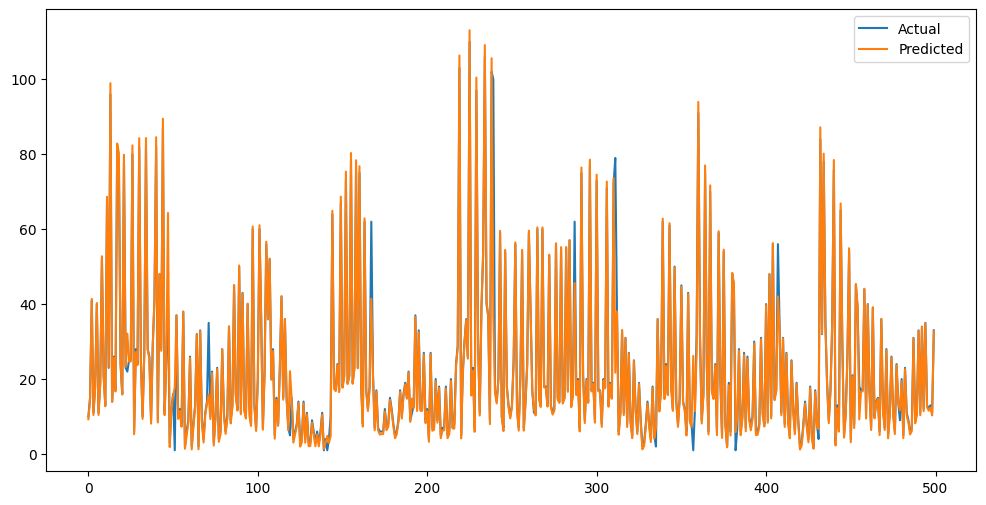

In [9]:
plt.figure(figsize=(12,6))
plt.plot(actual[:500],label="Actual")
plt.plot(preds[:500],label="Predicted")
plt.legend()
plt.show()


In [10]:
class LSTM_LLM(nn.Module):
    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(1, 64, batch_first=True)

        self.input_proj = nn.Linear(64, 128)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=8,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)

        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.input_proj(x)
        x = self.transformer(x)
        return self.fc(x)


In [11]:
model = LSTM_LLM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = nn.MSELoss()

for epoch in range(40):
    total_loss = 0
    for batch_x, batch_y in loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print("Epoch",epoch+1,"Loss",total_loss)


Epoch 1 Loss 28.9937106766738
Epoch 2 Loss 10.715399672510102
Epoch 3 Loss 2.061720598023385
Epoch 4 Loss 1.3574987721513025
Epoch 5 Loss 1.0924056100775488
Epoch 6 Loss 0.9489996566844638
Epoch 7 Loss 0.8658846332982648
Epoch 8 Loss 0.8321278736693785
Epoch 9 Loss 0.8063539788126945
Epoch 10 Loss 0.7775483221630566
Epoch 11 Loss 0.7457673782482743
Epoch 12 Loss 0.7456390258303145
Epoch 13 Loss 0.7396526045631617
Epoch 14 Loss 0.6974800704338122
Epoch 15 Loss 0.6911987271887483
Epoch 16 Loss 0.6795606911036884
Epoch 17 Loss 0.6864129241293995
Epoch 18 Loss 0.6706802954286104
Epoch 19 Loss 0.679255063078017
Epoch 20 Loss 0.6586895764776273
Epoch 21 Loss 0.6609769028727897
Epoch 22 Loss 0.660748058828176
Epoch 23 Loss 0.6419474186841398
Epoch 24 Loss 0.6561161625868408
Epoch 25 Loss 0.6401498178311158
Epoch 26 Loss 0.6356303452630527
Epoch 27 Loss 0.6397447202834883
Epoch 28 Loss 0.6238947617239319
Epoch 29 Loss 0.6374501134559978
Epoch 30 Loss 0.631024344402249
Epoch 31 Loss 0.625689631

In [12]:
model.eval()
preds, actual = [], []

with torch.no_grad():
    for batch_x, batch_y in loader:
        out = model(batch_x)
        preds.append(out.numpy())
        actual.append(batch_y.numpy())

preds = np.concatenate(preds)
actual = np.concatenate(actual)

preds = scaler.inverse_transform(preds.reshape(-1,1)).flatten()
actual = scaler.inverse_transform(actual.reshape(-1,1)).flatten()

mae = mean_absolute_error(actual,preds)
rmse = np.sqrt(mean_squared_error(actual,preds))

print("MAE:",mae)
print("RMSE:",rmse)


MAE: 1.251225471496582
RMSE: 3.539489316150089


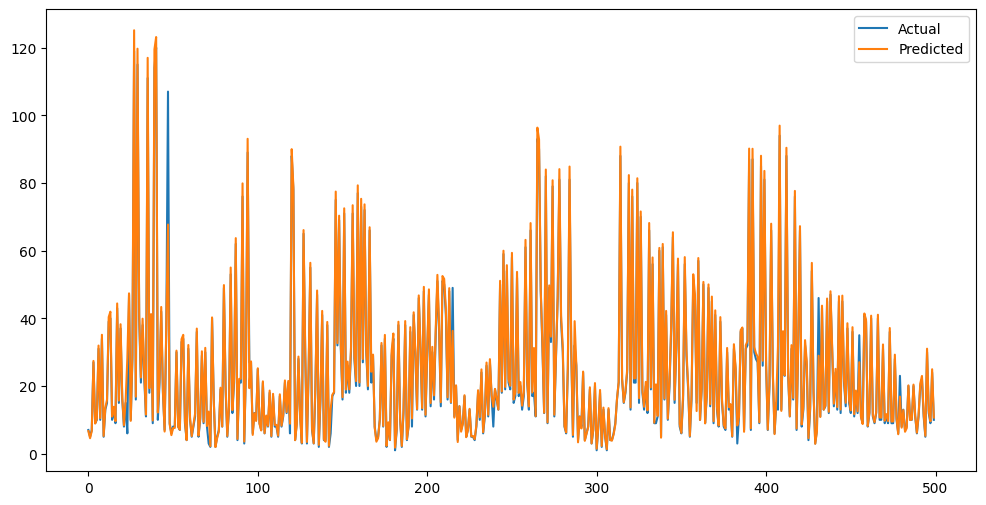

In [13]:
plt.figure(figsize=(12,6))
plt.plot(actual[:500],label="Actual")
plt.plot(preds[:500],label="Predicted")
plt.legend()
plt.show()


In [7]:
class GRU_LLM(nn.Module):
    def __init__(self):
        super().__init__()

        self.gru = nn.GRU(1, 64, batch_first=True)   # GRU feature extraction

        self.input_proj = nn.Linear(64, 128)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=8,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)

        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.input_proj(x)
        x = self.transformer(x)
        return self.fc(x)


In [8]:
model = GRU_LLM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = nn.MSELoss()

for epoch in range(40):
    total_loss = 0
    for batch_x, batch_y in loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print("Epoch",epoch+1,"Loss",total_loss)


Epoch 1 Loss 31.191582119558007
Epoch 2 Loss 10.43881143676117
Epoch 3 Loss 2.4518286188831553
Epoch 4 Loss 1.5353720016719308
Epoch 5 Loss 1.194567973841913
Epoch 6 Loss 1.0196241075464059
Epoch 7 Loss 0.9532684663427062
Epoch 8 Loss 0.9073403878719546
Epoch 9 Loss 0.8259878042736091
Epoch 10 Loss 0.7947112306865165
Epoch 11 Loss 0.8078472056076862
Epoch 12 Loss 0.7465168267081026
Epoch 13 Loss 0.8095088854170172
Epoch 14 Loss 0.7218785655277316
Epoch 15 Loss 0.7027675230492605
Epoch 16 Loss 0.7290654997195816
Epoch 17 Loss 0.7035984323883895
Epoch 18 Loss 0.6789527114160592
Epoch 19 Loss 0.7114514322020113
Epoch 20 Loss 0.6635234617278911
Epoch 21 Loss 0.6707437795703299
Epoch 22 Loss 0.6461993519187672
Epoch 23 Loss 0.6666399372334126
Epoch 24 Loss 0.6417850917569012
Epoch 25 Loss 0.6367940482159611
Epoch 26 Loss 0.6463697619328741
Epoch 27 Loss 0.6341385320702102
Epoch 28 Loss 0.6251374927305733
Epoch 29 Loss 0.6408192427261383
Epoch 30 Loss 0.6265893750241958
Epoch 31 Loss 0.67251

In [9]:
model.eval()
preds, actual = [], []

with torch.no_grad():
    for batch_x, batch_y in loader:
        out = model(batch_x)
        preds.append(out.numpy())
        actual.append(batch_y.numpy())

preds = np.concatenate(preds)
actual = np.concatenate(actual)

preds = scaler.inverse_transform(preds.reshape(-1,1)).flatten()
actual = scaler.inverse_transform(actual.reshape(-1,1)).flatten()

mae = mean_absolute_error(actual,preds)
rmse = np.sqrt(mean_squared_error(actual,preds))

print("MAE:",mae)
print("RMSE:",rmse)


MAE: 1.2767131328582764
RMSE: 3.606564571207151


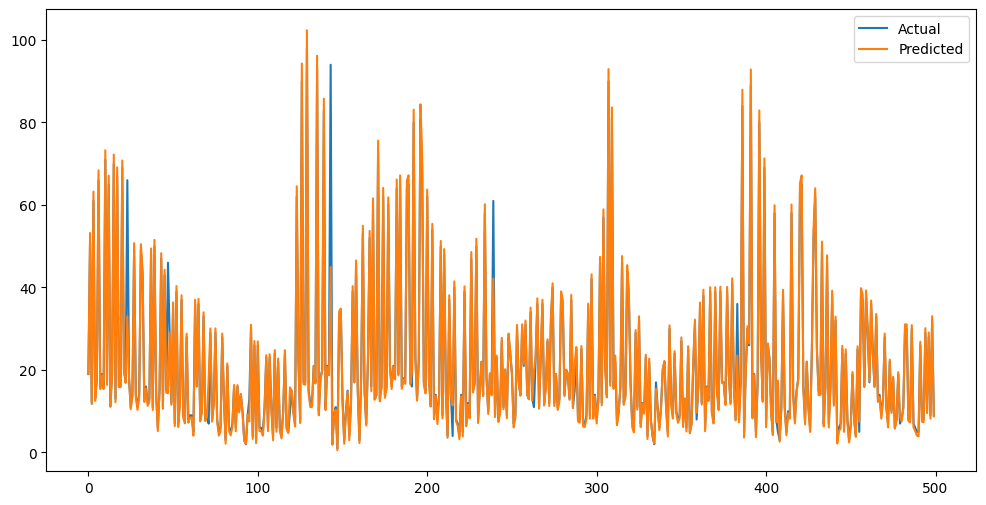

In [10]:
plt.figure(figsize=(12,6))
plt.plot(actual[:500],label="Actual")
plt.plot(preds[:500],label="Predicted")
plt.legend()
plt.show()


In [36]:
A = torch.tensor([
    [1,1,0,0],
    [1,1,1,0],
    [0,1,1,1],
    [0,0,1,1]
], dtype=torch.float32)

A = A / A.sum(dim=1, keepdim=True)


In [45]:
class GNNLayer(nn.Module):
    def __init__(self, num_nodes):
        super().__init__()
        self.linear = nn.Linear(num_nodes, num_nodes)

    def forward(self, x, A):

        if x.dim() == 3:          # if shape (batch, nodes, 1)
            x = x.squeeze(-1)

        A_batch = A.unsqueeze(0).repeat(x.size(0),1,1)

        x = torch.bmm(A_batch, x.unsqueeze(-1)).squeeze(-1)

        return self.linear(x)


In [48]:
class GNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gnn1 = GNNLayer(4)
        self.relu = nn.ReLU()

    def forward(self, x):
        seq = []       for t in range(x.shape[1]):
            xt = x[:,t,:]
            xt = self.relu(self.gnn1(xt, A))
            seq.append(xt.unsqueeze(1))
        return torch.cat(seq, dim=1)


In [49]:
model = GNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = nn.MSELoss()

for epoch in range(30):
    total_loss = 0
    for batch_x, batch_y in loader:
        optimizer.zero_grad()
        out = model(batch_x)
        loss = criterion(out, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    print("Epoch", epoch+1, "Loss", total_loss)


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [32, 4] but got: [32, 1].